In [1]:
"""
Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20


Asrita, please conduct some form of hyper parameter tuning by evaluating the effect of the following parmeters
on the final all-class test F1 score after bias calibration is performed.
    - pre_dim (dimensionality of first hidden layer)
        - try [10, 25, 50, 100, 300]
    - post_dim (dimensionality of second hidden layer)
        - try [10, 25, 50, 100, 300]
    - C (number of dummy classifiers)
        - try [1, 5, 10, 25, 50 , 100, 250]
    - alpha (parameter to the beta distribution which determines how manifold mixup in conducted)
        - try values [.5,1,2,5]
    - beta (l1 loss coefficient determining impact of masked probability)
        - try values [.1, .25, .5, .75, .9, 1]
    - gamma (weighting of l2 loss, aka how much do we care about data placeholders)
        - try values [.1, .25, .5, .75, .9, 1]
"""

'\nPurpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"\n    and compare its performance to simple confidence thresholding on a logistic regression classifier.\n\nFollowing https://builtin.com/data-science/guide-logistic-regression-tensorflow-20\n\nNote (10/27/2022):\nI would like to set up an ablation study to see the effect of the following hyper parameters\non the all-class and open-set (one vs rest) F1 scores:\n    - C (number of dummy classifiers)\n    - beta (l1 loss coefficient determining impact of masked probability)\n'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tqdm import tqdm

In [127]:
NUM_CLASSES = 100
NUM_FEATURES = 768
OPEN_SET_LABELS = list(range(100, 200))

def data_split(X, y, val_size=.2):
    """Input are expected to be tensors.
    """
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X1, X2, y1, y2 = map(tensor, train_test_split(X.numpy(), y.numpy(), test_size=val_size))
    return X1, X2, y1, y2

def load_dataset():
    X_train = tf.convert_to_tensor(
        np.load('/Users/jmmar/github/CSE-576-Group-Project/data/embeddings/train/train_embeddings.npy'), 
        #np.load('/Users/jmmar/github/CSE-576-Group-Project/data/embeddings_model_0.npy'),
        dtype=tf.float32
    )
    X_test = tf.convert_to_tensor(
        np.load('/Users/jmmar/github/CSE-576-Group-Project/data/embeddings/test/test_embeddings.npy'), 
        dtype=tf.float32
    )
    y_train = tf.convert_to_tensor(
        np.load('/Users/jmmar/github/CSE-576-Group-Project/data/embeddings/train/labels.npy'), 
        #np.load('/Users/jmmar/github/CSE-576-Group-Project/data/labels.npy'),
        dtype=tf.float32
    )
    y_test = tf.convert_to_tensor(
        np.load('/Users/jmmar/github/CSE-576-Group-Project/data/embeddings/test/labels.npy'), 
        dtype=tf.float32
    )
    return X_train, X_test, y_train, y_test

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = tf.reduce_all([y != label for label in class_labels], axis=0)
    y = tf.boolean_mask(y, to_remove_mask)
    X = tf.boolean_mask(X, to_remove_mask)
    return X, y

In [128]:
X, X_test, y, y_test = load_dataset()
X_test, X_val, y_test, y_val = data_split(X_test, y_test, .2) # split off 20% of test data as a validation set

X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, OPEN_SET_LABELS)
y_val_closed_one_hot = tf.one_hot(tf.cast(y_val_closed, tf.int64), depth=NUM_CLASSES)
y_val_closed_one_hot_extra = tf.one_hot(tf.cast(y_val_closed, tf.int64), depth=NUM_CLASSES + 1)

In [129]:
print('X train: ', X.shape)
print('y train: ', y.shape)
print('X val: ', X_val.shape)
print('y val: ', y_val.shape)
print('X test: ', X_test.shape)
print('y test: ', y_test.shape)
print('X val closed: ', X_val_closed.shape)
print('y val closed one-hot: ', y_val_closed_one_hot.shape)

X train:  (49999, 768)
y train:  (49999,)
X val:  (4000, 768)
y val:  (4000,)
X test:  (16000, 768)
y test:  (16000,)
X val closed:  (2049, 768)
y val closed one-hot:  (2049, 100)


In [15]:
def plot_training_metric(train_values, val_values, metric_name):
    iterations = list(range(len(train_values)))
    plt.plot(iterations, train_values, label='Train')
    plt.plot(iterations, val_values, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title('{} While Training'.format(metric_name))
    plt.show()

In [93]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, num_classes, pre_dim=50, post_dim=50, *args, **kwargs):
        super().__init__(*args, **kwargs)
        lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim, activation=lrelu, name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation=lrelu, name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        logits = self.logits_layer(x_post)
        return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

def train_SLRM(X, y, num_classes, epochs=25, plot=True, **kwargs):
    model = StandardLogisticRegressionModel( 
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        loss=ce_loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes, average='macro')]
    )
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_data=(X_val_closed, y_val_closed_one_hot),
        callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

Epoch 1/15
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2194 - f1: 0.9660 - val_loss: 0.8942 - val_f1: 0.8455
Epoch 2/15
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0532 - f1: 0.9894 - val_loss: 0.8800 - val_f1: 0.8566
Epoch 3/15
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0375 - f1: 0.9915 - val_loss: 0.9381 - val_f1: 0.8538
Epoch 4/15
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0270 - f1: 0.9935 - val_loss: 1.0087 - val_f1: 0.8550
Epoch 5/15
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0209 - f1: 0.9947 - val_loss: 1.1481 - val_f1: 0.8548
Epoch 6/15
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0143 - f1: 0.9963 - val_loss: 1.1620 - val_f1: 0.8616
Epoch 7/15
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0130 - f1: 0.9964 - val_loss: 1.2943 - val_f1: 0.8519
Epoch 8/15
1563/1563 [==============================] - 2s 1ms/step - loss: 

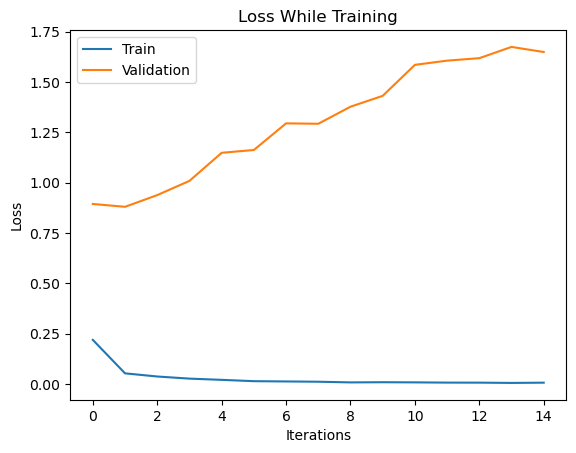

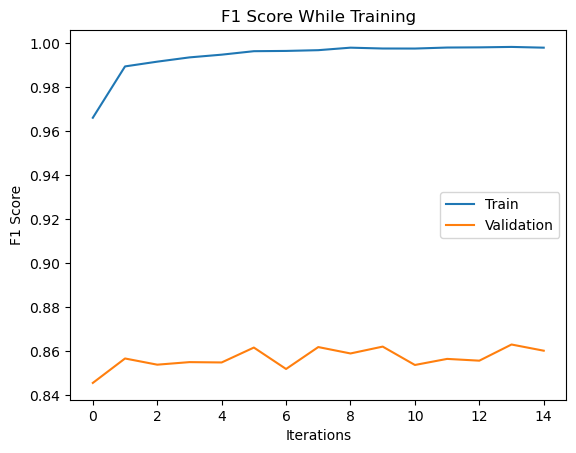

In [130]:
model = train_SLRM(X, y, num_classes=NUM_CLASSES, epochs=15, plot=True, pre_dim=50, post_dim=50)

In [95]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
    
def threshold_predict(X, model, threshold):
    y_pred = model.call(X)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def open_set_f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.where(y_true == -1, 1, 0)
    y_pred = tf.where(y_pred == -1, 1, 0)
    return f1_score(y_true, y_pred)
    
def known_fraction(y_pred):
    """Fraction of predicted class labels != -1"""
    return tf.reduce_sum(tf.cast(y_pred != -1, tf.int64)) / y_pred.shape

In [96]:
def tune_model_param(model, val_closed, val_open, param_values, param_name, predict_func,
                     objective_func, target_value, objective_name, metrics, plot=True):
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val, OPEN_SET_LABELS)
    best_objective_error = float('inf')
    best_param_value = 0
    objective_values = []
    metric_values = {metric: [] for metric in metrics}
    for param_value in param_values:
        y_pred_closed = predict_func(val_closed['X'], model, param_value)
        y_pred_open = predict_func(val_open['X'], model, param_value)
        objective_values.append(objective_func(y_pred_closed))
        objective_error = float(abs(objective_values[-1] - target_value))
        if objective_error < best_objective_error:
            best_objective_error = objective_error
            best_param_value = param_value
        for metric in metrics:
            metric_values[metric].append(metrics[metric](val_open['y'], y_pred_open))
    if plot:
        for metric in metrics:
            plt.plot(param_values, metric_values[metric], label=metric)
        plt.plot(param_values, objective_values, label=objective_name)
        plt.xlabel(param_name)
        plt.legend()
        plt.title('Calibrating {}'.format(param_name))
        plt.show()
    return best_param_value

In [97]:
# See how the threshold value affects accuracy and find the threshold
# such that 95% of validation data is recognized as known

tuning_metrics = {
    'All Class F1': lambda *x: f1_score(*x, average='macro'),
    'Open-Set F1': open_set_f1_score,
    'All Class Accuracy': accuracy,
    'Open-Set Accuracy': open_set_accuracy,    
}

def tune_TSLR_threshold(model, X_val, y_val, plot=True):
    """Tunes a Thresholded-Standard-Logistic-Regression model's threshold so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    threshold_values = np.linspace(0, 1, 100)
    target_known_fraction = .95
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = data_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, OPEN_SET_LABELS)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, OPEN_SET_LABELS)
    val_closed = {'X': X_val_closed, 'y': y_val_closed}
    val_open = {'X': X_val_open, 'y': y_val_open}
    param_name = 'Classification Probability Threshold'
    objective_name = 'Known Fraction'
    threshold = tune_model_param(
        model, val_closed, val_open, threshold_values, param_name, threshold_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return threshold

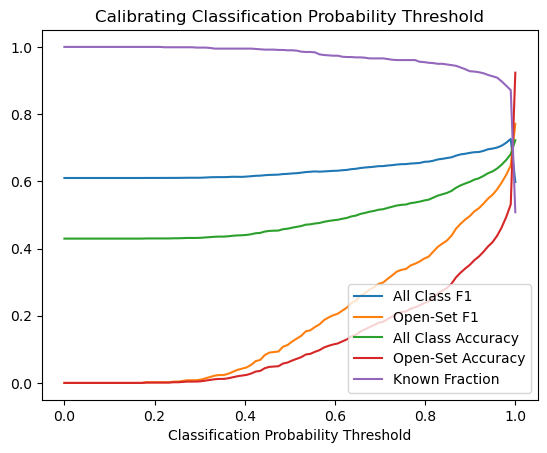

Results from test set using 95% threshold (0.8283):
All Class F1: 0.6577
Open-Set F1: 0.4020
All Class Accuracy: 0.5531
Open-Set Accuracy: 0.2674


In [98]:
threshold = tune_TSLR_threshold(model, X_val, y_val)

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

y_pred = threshold_predict(X_test, model, threshold)
print('Results from test set using 95% threshold ({:.4f}):'.format(threshold))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [105]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')
        self.bias = 0 # used to calibrate dummy logit to have same magnitude as rest of logits

    def _pre(self, inputs):
        return self.embed_pre(inputs)
    
    def _rest(self, inputs):
        x_post = self.embed_post(inputs)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1) + self.bias], axis=1)
        return self.output_layer(all_logits)
        
    def call(self, inputs):
        x_pre = self._pre(inputs)
        return self._rest(x_pre)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.call(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)    
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss

def train_OSPLRM(X, y, num_classes, beta=.5, epochs=25, plot=True, **kwargs):
    model = OpenSetPlaceholdersLRM(
        num_classes=num_classes,
        **kwargs
    )
    loss = lambda *x: ce_loss_for_placeholders(*x, beta)
    model.compile(
        optimizer='adam', 
        loss=loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes+1, average='macro')]
    )
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes + 1)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_data=(X_val_closed, y_val_closed_one_hot_extra), 
        batch_size=32,callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

Epoch 1/15
1485/1485 [==============================] - 3s 2ms/step - loss: 1.4389 - f1: 0.8630 - val_loss: 1.9480 - val_f1: 0.7375
Epoch 2/15
1485/1485 [==============================] - 2s 2ms/step - loss: 1.2130 - f1: 0.9313 - val_loss: 1.9648 - val_f1: 0.7605
Epoch 3/15
1485/1485 [==============================] - 2s 1ms/step - loss: 1.1985 - f1: 0.9425 - val_loss: 1.9614 - val_f1: 0.7941
Epoch 4/15
1485/1485 [==============================] - 2s 1ms/step - loss: 1.1885 - f1: 0.9495 - val_loss: 1.9819 - val_f1: 0.7871
Epoch 5/15
1485/1485 [==============================] - 2s 1ms/step - loss: 1.1811 - f1: 0.9550 - val_loss: 1.9923 - val_f1: 0.8075
Epoch 6/15
1485/1485 [==============================] - 2s 1ms/step - loss: 1.1758 - f1: 0.9605 - val_loss: 1.9872 - val_f1: 0.7871
Epoch 7/15
1485/1485 [==============================] - 2s 1ms/step - loss: 1.1715 - f1: 0.9648 - val_loss: 2.0504 - val_f1: 0.8033
Epoch 8/15
1485/1485 [==============================] - 2s 1ms/step - loss: 

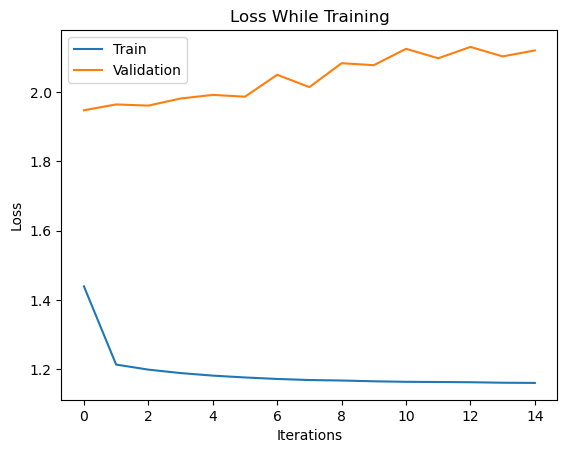

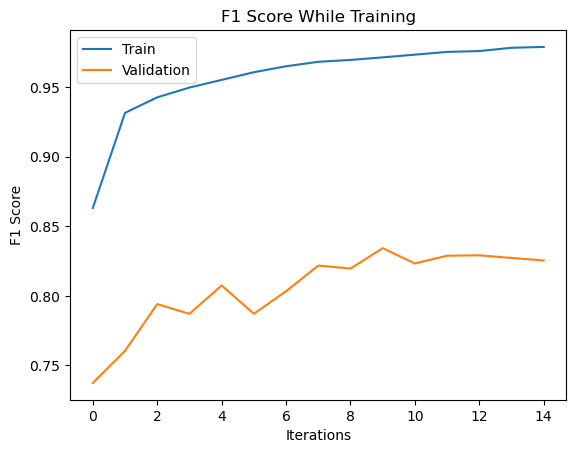

In [106]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set

model = train_OSPLRM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=15,
    num_placeholders=20,
    pre_dim=50,
    post_dim=50,
    beta=.7,
    plot=True,
)

In [107]:
# See how the bias value affects accuracy and find the bias
# such that 95% of validation data is recognized as known

def tune_OSPLRM_threshold(model, X_val, y_val, plot=True):
    """Tunes a Open-Set-Placeholders-Logistic-Regression model's bias so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    def placeholders_predict(X, model, bias):
        model.bias = bias
        return model.predict(X)

    target_known_fraction = .95
    bias_values = np.linspace(-2, 2, 100)
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = data_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, OPEN_SET_LABELS)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, OPEN_SET_LABELS)
    val_closed = {'X': X_val_closed, 'y': y_val_closed}
    val_open = {'X': X_val_open, 'y': y_val_open}
    param_name = 'Dummy Classifier Bias'
    objective_name = 'Known Fraction'
    bias = tune_model_param(
        model, val_closed, val_open, bias_values, param_name, placeholders_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return bias

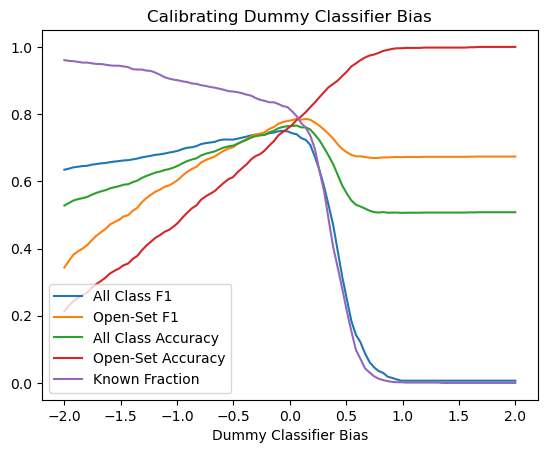

Results from test set using 95% bias (-1.7172):
All Class F1: 0.6631
Open-Set F1: 0.4216
All Class Accuracy: 0.5677
Open-Set Accuracy: 0.2812


In [108]:
bias = tune_OSPLRM_threshold(model, X_val, y_val)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [115]:
### THE CODE BELOW IS A WORK IN PROGRESS AND DOES NOT CURRENTLY RUN ###


"""We will now introduce data placeholders. In essence, we will be synthesizing open-set training
data via a process called "manifold mixup". We will also introduce a new loss function which makes
use of the new synthetic data.
"""

# Open set placeholder
class OSPWithDataPlaceholdersLRM(OpenSetPlaceholdersLRM):
    def __init__(self, alpha, beta, gamma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    def train_step(self, data):
        X, y = data
        X_part1, X_part2 = tf.split(X, 2)
        y_part1, y_part2 = tf.split(y, 2)
        # create a new y_true where the true label is the open-set class
        rows, cols = y_part2.shape
        rows = rows or 1
        y_part2_new = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
        
        with tf.GradientTape() as tape:
            # caldulate the first portion of the loss on the first half of the batch
            y_part1_pred = self.call(X_part1)
            loss1 = ce_loss_for_placeholders(y_part1, y_part1_pred, self.beta)
            # perform manifold mixup and calculate the second part of the loss
            X_part2_pre = self._pre(X_part2)
            X_part2_pre_hat = self.manifold_mixup(X_part2_pre)
            y_part2_pred = self._rest(X_part2_pre_hat)
            loss2 = ce_loss(y_part2_new, y_part2_pred)
            # calculated weighted sum of losses
            loss = loss1 + self.gamma * loss2
            
        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics using the predictions from batch part 1
        self.compiled_metrics.update_state(y_part1, y_part1_pred)
        results = {m.name: m.result() for m in self.metrics}
        results['loss'] = loss
        return results
    
    def manifold_mixup(self, X_pre):
        """
        """
        alpha = tf.constant(self.alpha)
        dist = tfp.distributions.Beta(alpha, alpha)
        lam = dist.sample(1)
        if not X_pre.shape[0]:
            return X_pre
        indices = tf.random.shuffle(tf.range(X_pre.shape[0]))
        X_pre_hat = lam * X_pre + (1 - lam) * tf.gather(X_pre, indices)
        return X_pre_hat

def train_OSPWDPLSM(X, y, num_classes, batch_size=64, epochs=25, plot=True, **kwargs):
    model = OSPWithDataPlaceholdersLRM(
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes+1, average='macro')]
    )
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes + 1)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    # ensure the length of the training dataset is a multiple of the batch_size
    num_train_samples = (X.shape[0] // batch_size) * batch_size
    X = X[:num_train_samples]
    y_train_one_hot = y_train_one_hot[:num_train_samples]
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_data=(X_val_closed, y_val_closed_one_hot_extra), 
        batch_size=batch_size, callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
        plt.plot(history['loss'])
        plt.title('Training Loss')
        plt.xlabel('epoch')
        plt.show()
    return model

Epoch 1/35
742/742 [==============================] - 2s 2ms/step - f1: 0.7616 - loss: 1.7748 - val_loss: 0.0000e+00 - val_f1: 0.6849
Epoch 2/35
742/742 [==============================] - 1s 2ms/step - f1: 0.8618 - loss: 1.2678 - val_loss: 0.0000e+00 - val_f1: 0.6466
Epoch 3/35
742/742 [==============================] - 1s 2ms/step - f1: 0.8766 - loss: 1.2322 - val_loss: 0.0000e+00 - val_f1: 0.6881
Epoch 4/35
742/742 [==============================] - 1s 2ms/step - f1: 0.8805 - loss: 1.2143 - val_loss: 0.0000e+00 - val_f1: 0.6950
Epoch 5/35
742/742 [==============================] - 1s 2ms/step - f1: 0.8900 - loss: 1.2434 - val_loss: 0.0000e+00 - val_f1: 0.7503
Epoch 6/35
742/742 [==============================] - 1s 1ms/step - f1: 0.8928 - loss: 1.2630 - val_loss: 0.0000e+00 - val_f1: 0.7269
Epoch 7/35
742/742 [==============================] - 1s 1ms/step - f1: 0.8928 - loss: 1.2768 - val_loss: 0.0000e+00 - val_f1: 0.7348
Epoch 8/35
742/742 [==============================] - 1s 2ms/s

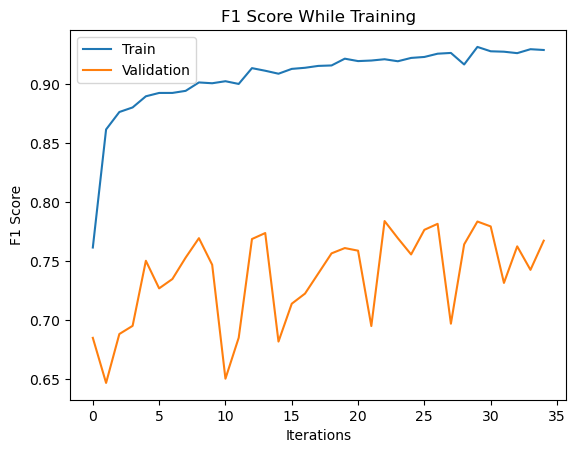

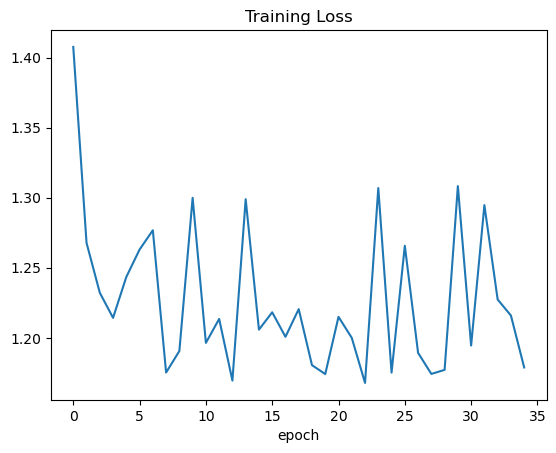

In [116]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set

model = train_OSPWDPLSM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=35,
    num_placeholders=20,
    pre_dim=50,
    post_dim=50,
    alpha=2.0,
    beta=.7,
    gamma=.2,
    plot=True,
)

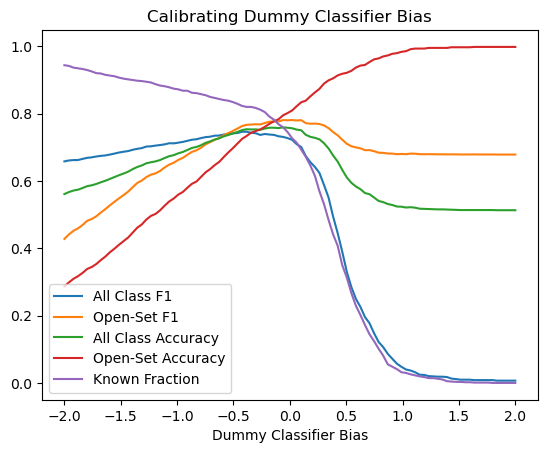

Results from test set using 95% bias (-2.0000):
All Class F1: 0.6667
Open-Set F1: 0.4178
All Class Accuracy: 0.5639
Open-Set Accuracy: 0.2803


In [117]:
bias = tune_OSPLRM_threshold(model, X_val, y_val, OPEN_SET_LABELS)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

Epoch 1/75
1485/1485 [==============================] - 2s 1ms/step - loss: 2.9450 - f1: 0.0899 - val_loss: 3.3808 - val_f1: 0.0893
Epoch 2/75
1485/1485 [==============================] - 2s 1ms/step - loss: 2.1853 - f1: 0.2483 - val_loss: 3.2718 - val_f1: 0.2112
Epoch 3/75
1485/1485 [==============================] - 2s 1ms/step - loss: 1.9121 - f1: 0.3716 - val_loss: 3.2387 - val_f1: 0.2726
Epoch 4/75
1485/1485 [==============================] - 2s 1ms/step - loss: 1.7273 - f1: 0.4624 - val_loss: 3.1720 - val_f1: 0.3239
Epoch 5/75
1485/1485 [==============================] - 2s 1ms/step - loss: 1.5881 - f1: 0.5289 - val_loss: 3.1012 - val_f1: 0.3873
Epoch 6/75
1485/1485 [==============================] - 2s 1ms/step - loss: 1.4724 - f1: 0.5780 - val_loss: 3.1108 - val_f1: 0.4088
Epoch 7/75
1485/1485 [==============================] - 2s 1ms/step - loss: 1.3786 - f1: 0.6191 - val_loss: 3.0554 - val_f1: 0.4918
Epoch 8/75
1485/1485 [==============================] - 2s 1ms/step - loss: 

1485/1485 [==============================] - 2s 1ms/step - loss: 0.3255 - f1: 0.9551 - val_loss: 3.3643 - val_f1: 0.6709
Epoch 63/75
1485/1485 [==============================] - 2s 1ms/step - loss: 0.3191 - f1: 0.9554 - val_loss: 3.3153 - val_f1: 0.6943
Epoch 64/75
1485/1485 [==============================] - 2s 1ms/step - loss: 0.3081 - f1: 0.9573 - val_loss: 3.2902 - val_f1: 0.7041
Epoch 65/75
1485/1485 [==============================] - 2s 1ms/step - loss: 0.3122 - f1: 0.9567 - val_loss: 3.2630 - val_f1: 0.7104
Epoch 66/75
1485/1485 [==============================] - 2s 1ms/step - loss: 0.3196 - f1: 0.9582 - val_loss: 3.3113 - val_f1: 0.7001
Epoch 67/75
1485/1485 [==============================] - 2s 1ms/step - loss: 0.3023 - f1: 0.9578 - val_loss: 3.2669 - val_f1: 0.7118
Epoch 68/75
1485/1485 [==============================] - 2s 1ms/step - loss: 0.3102 - f1: 0.9577 - val_loss: 3.2838 - val_f1: 0.7027
Epoch 69/75
1485/1485 [==============================] - 2s 1ms/step - loss: 0.29

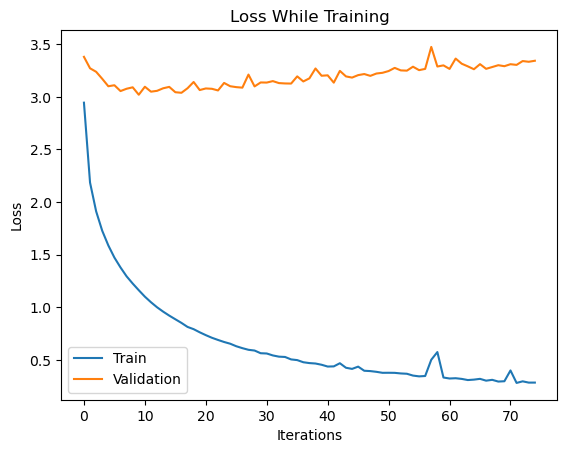

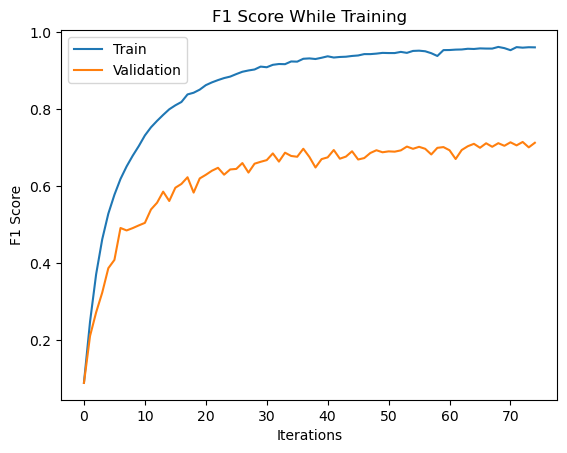

In [119]:
"""We will now look at how well the various methods separate the image embeddings by learning a 
R^d -> R^2 embedding module and plotting the various class embedding clusters.
"""

# Standard Logistic Regression trained on closed set 0-8 (9 held out)

model = train_SLRM(
    X, y, 
    num_classes=NUM_CLASSES, 
    epochs=75, 
    plot=True, 
    pre_dim=50, 
    post_dim=2
)

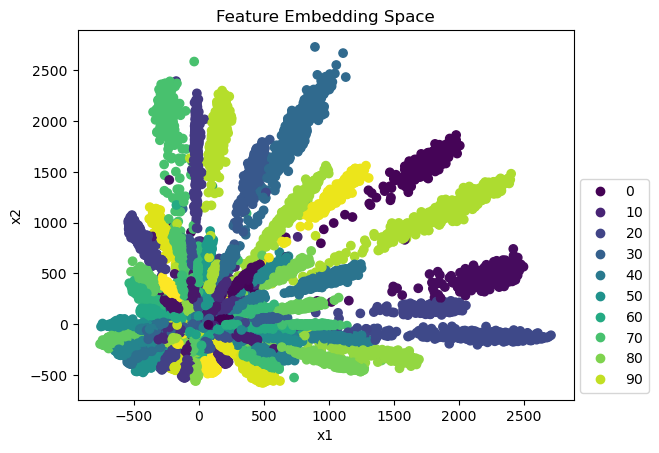

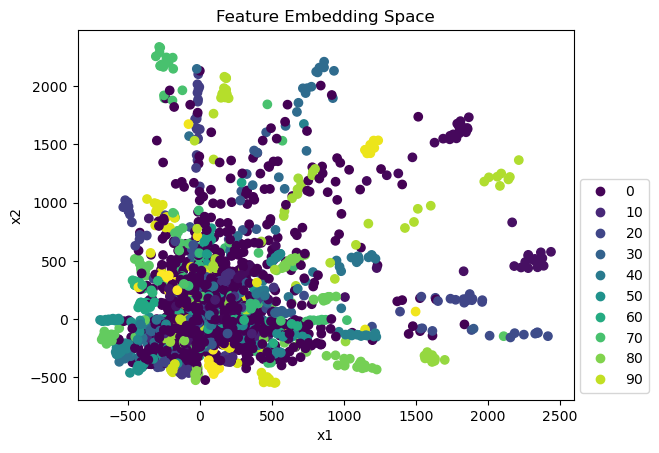

In [121]:
def plot_post_embeddings(model, X, y):
    X_pre = model.embed_pre(X)
    X_post = model.embed_post(X_pre)
    scatter = plt.scatter(X_post[:,0], X_post[:,1], c=y)
    plt.legend(*scatter.legend_elements(), loc='lower left', bbox_to_anchor=(1,0))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Feature Embedding Space')
    plt.show()

plot_post_embeddings(model, X, y)
y_val_open = modify_open_set_labels(y_val, OPEN_SET_LABELS)
plot_post_embeddings(model, X_val, y_val_open)

Epoch 1/150
1485/1485 [==============================] - 3s 2ms/step - loss: 4.6814 - f1: 0.0049 - val_loss: 5.0566 - val_f1: 0.0085
Epoch 2/150
1485/1485 [==============================] - 2s 1ms/step - loss: 3.7226 - f1: 0.0174 - val_loss: 4.9324 - val_f1: 0.0185
Epoch 3/150
1485/1485 [==============================] - 3s 2ms/step - loss: 3.4815 - f1: 0.0310 - val_loss: 4.8212 - val_f1: 0.0344
Epoch 4/150
1485/1485 [==============================] - 2s 2ms/step - loss: 3.3216 - f1: 0.0525 - val_loss: 4.6481 - val_f1: 0.0501
Epoch 5/150
1485/1485 [==============================] - 2s 1ms/step - loss: 3.1808 - f1: 0.0815 - val_loss: 4.5538 - val_f1: 0.0781
Epoch 6/150
1485/1485 [==============================] - 2s 1ms/step - loss: 3.0513 - f1: 0.1109 - val_loss: 4.4963 - val_f1: 0.0782
Epoch 7/150
1485/1485 [==============================] - 2s 1ms/step - loss: 2.9382 - f1: 0.1393 - val_loss: 4.4011 - val_f1: 0.1165
Epoch 8/150
1485/1485 [==============================] - 2s 1ms/step 

1485/1485 [==============================] - 2s 1ms/step - loss: 2.0301 - f1: 0.5044 - val_loss: 4.6413 - val_f1: 0.3527
Epoch 63/150
1485/1485 [==============================] - 2s 1ms/step - loss: 2.0251 - f1: 0.5067 - val_loss: 4.6889 - val_f1: 0.3264
Epoch 64/150
1485/1485 [==============================] - 2s 1ms/step - loss: 2.0226 - f1: 0.5099 - val_loss: 4.6341 - val_f1: 0.3449
Epoch 65/150
1485/1485 [==============================] - 2s 1ms/step - loss: 2.0166 - f1: 0.5134 - val_loss: 4.6144 - val_f1: 0.3688
Epoch 66/150
1485/1485 [==============================] - 2s 1ms/step - loss: 2.0149 - f1: 0.5139 - val_loss: 4.6415 - val_f1: 0.3768
Epoch 67/150
1485/1485 [==============================] - 2s 1ms/step - loss: 2.0094 - f1: 0.5149 - val_loss: 4.6409 - val_f1: 0.3643
Epoch 68/150
1485/1485 [==============================] - 2s 1ms/step - loss: 2.0053 - f1: 0.5146 - val_loss: 4.7032 - val_f1: 0.3651
Epoch 69/150
1485/1485 [==============================] - 2s 1ms/step - los

1485/1485 [==============================] - 2s 2ms/step - loss: 1.8743 - f1: 0.5902 - val_loss: 4.8336 - val_f1: 0.3754
Epoch 124/150
1485/1485 [==============================] - 2s 1ms/step - loss: 1.8810 - f1: 0.5897 - val_loss: 4.8181 - val_f1: 0.4188
Epoch 125/150
1485/1485 [==============================] - 2s 1ms/step - loss: 1.8707 - f1: 0.5915 - val_loss: 4.8459 - val_f1: 0.3446
Epoch 126/150
1485/1485 [==============================] - 2s 1ms/step - loss: 1.8683 - f1: 0.5923 - val_loss: 4.8445 - val_f1: 0.4068
Epoch 127/150
1485/1485 [==============================] - 2s 1ms/step - loss: 1.8706 - f1: 0.5937 - val_loss: 4.8196 - val_f1: 0.3955
Epoch 128/150
1485/1485 [==============================] - 2s 1ms/step - loss: 1.8707 - f1: 0.5911 - val_loss: 4.8529 - val_f1: 0.3905
Epoch 129/150
1485/1485 [==============================] - 2s 1ms/step - loss: 1.8616 - f1: 0.5948 - val_loss: 4.8671 - val_f1: 0.3718
Epoch 130/150
1485/1485 [==============================] - 2s 1ms/ste

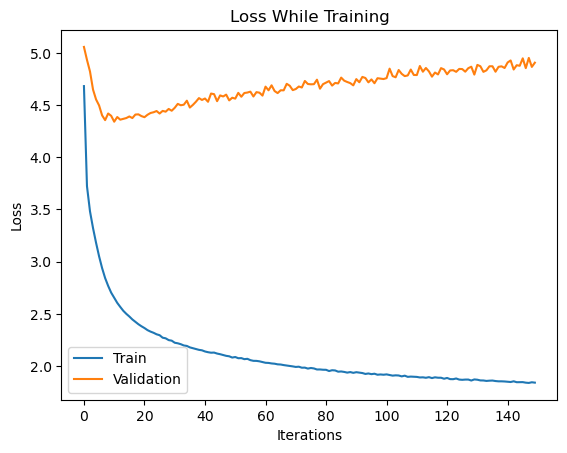

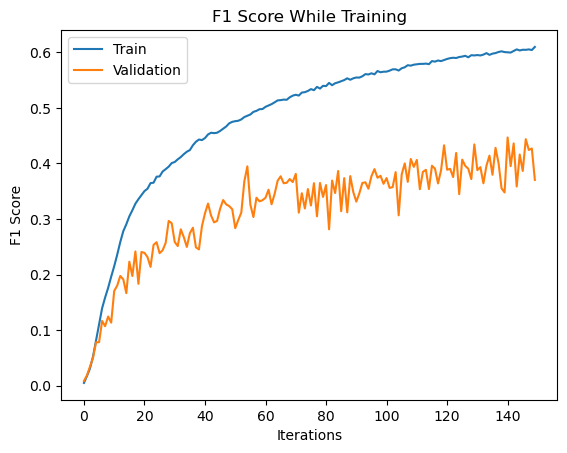

In [123]:
model = train_OSPLRM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=150,
    num_placeholders=20,
    pre_dim=50,
    post_dim=2,
    beta=.7,
    plot=True,
)

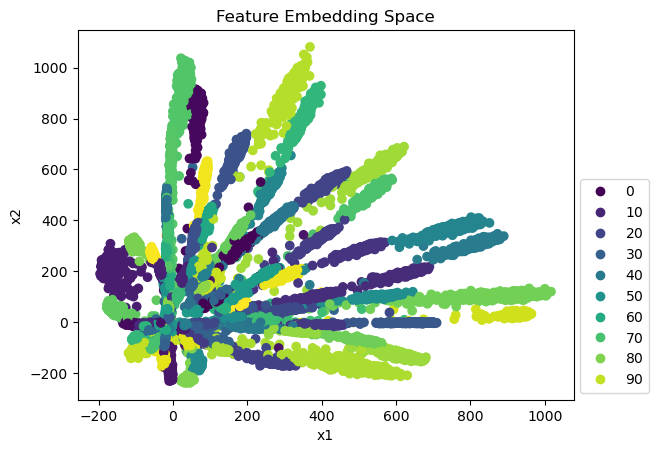

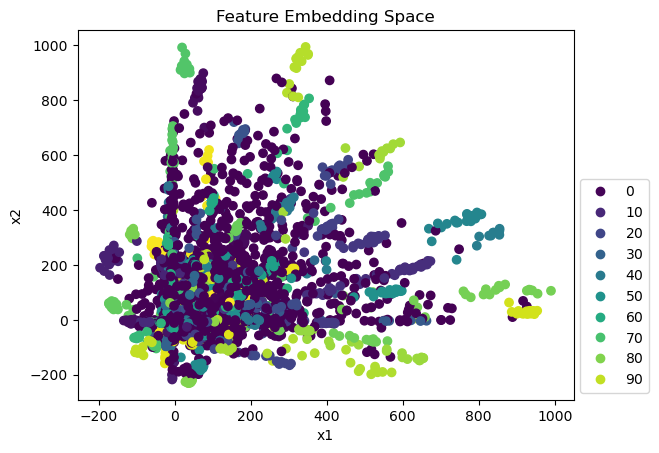

In [124]:
plot_post_embeddings(model, X, y)
y_val_open = modify_open_set_labels(y_val, OPEN_SET_LABELS)
plot_post_embeddings(model, X_val, y_val_open)

Epoch 1/150
742/742 [==============================] - 2s 2ms/step - f1: 0.0000e+00 - loss: 5.3968 - val_loss: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/150
742/742 [==============================] - 1s 2ms/step - f1: 0.0000e+00 - loss: 4.5186 - val_loss: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/150
742/742 [==============================] - 1s 2ms/step - f1: 4.0352e-04 - loss: 4.2683 - val_loss: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 4/150
742/742 [==============================] - 1s 2ms/step - f1: 0.0056 - loss: 4.4322 - val_loss: 0.0000e+00 - val_f1: 0.0052
Epoch 5/150
742/742 [==============================] - 1s 2ms/step - f1: 0.0104 - loss: 3.8607 - val_loss: 0.0000e+00 - val_f1: 0.0134
Epoch 6/150
742/742 [==============================] - 1s 2ms/step - f1: 0.0137 - loss: 3.8680 - val_loss: 0.0000e+00 - val_f1: 0.0066
Epoch 7/150
742/742 [==============================] - 1s 2ms/step - f1: 0.0181 - loss: 4.0422 - val_loss: 0.0000e+00 - val_f1: 0.0145
Epoch 8/150
742/742 [==========

742/742 [==============================] - 1s 2ms/step - f1: 0.2438 - loss: 2.7277 - val_loss: 0.0000e+00 - val_f1: 0.1240
Epoch 62/150
742/742 [==============================] - 1s 2ms/step - f1: 0.2457 - loss: 2.7955 - val_loss: 0.0000e+00 - val_f1: 0.1731
Epoch 63/150
742/742 [==============================] - 1s 2ms/step - f1: 0.2533 - loss: 2.6230 - val_loss: 0.0000e+00 - val_f1: 0.1626
Epoch 64/150
742/742 [==============================] - 1s 2ms/step - f1: 0.2549 - loss: 2.5278 - val_loss: 0.0000e+00 - val_f1: 0.1397
Epoch 65/150
742/742 [==============================] - 1s 2ms/step - f1: 0.2559 - loss: 2.6295 - val_loss: 0.0000e+00 - val_f1: 0.1574
Epoch 66/150
742/742 [==============================] - 1s 2ms/step - f1: 0.2576 - loss: 2.5773 - val_loss: 0.0000e+00 - val_f1: 0.1969
Epoch 67/150
742/742 [==============================] - 1s 2ms/step - f1: 0.2589 - loss: 2.6218 - val_loss: 0.0000e+00 - val_f1: 0.1843
Epoch 68/150
742/742 [==============================] - 1s 2m

742/742 [==============================] - 1s 2ms/step - f1: 0.3222 - loss: 2.5612 - val_loss: 0.0000e+00 - val_f1: 0.2146
Epoch 122/150
742/742 [==============================] - 1s 2ms/step - f1: 0.3263 - loss: 2.4827 - val_loss: 0.0000e+00 - val_f1: 0.2517
Epoch 123/150
742/742 [==============================] - 1s 2ms/step - f1: 0.3269 - loss: 3.3216 - val_loss: 0.0000e+00 - val_f1: 0.1981
Epoch 124/150
742/742 [==============================] - 1s 2ms/step - f1: 0.3272 - loss: 2.3907 - val_loss: 0.0000e+00 - val_f1: 0.2014
Epoch 125/150
742/742 [==============================] - 1s 2ms/step - f1: 0.3293 - loss: 2.4261 - val_loss: 0.0000e+00 - val_f1: 0.1859
Epoch 126/150
742/742 [==============================] - 1s 2ms/step - f1: 0.3282 - loss: 2.4238 - val_loss: 0.0000e+00 - val_f1: 0.2166
Epoch 127/150
742/742 [==============================] - 1s 2ms/step - f1: 0.3312 - loss: 2.4896 - val_loss: 0.0000e+00 - val_f1: 0.2046
Epoch 128/150
742/742 [==============================] 

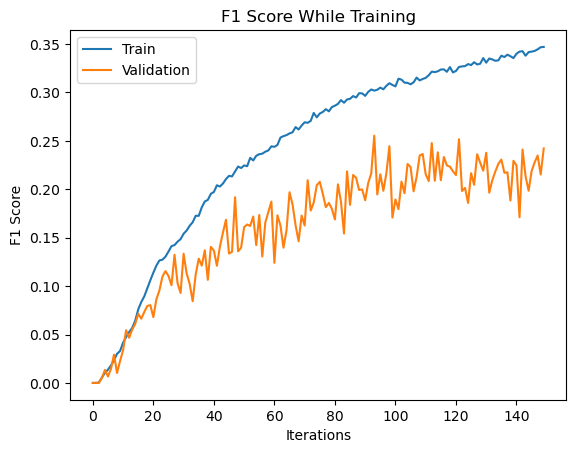

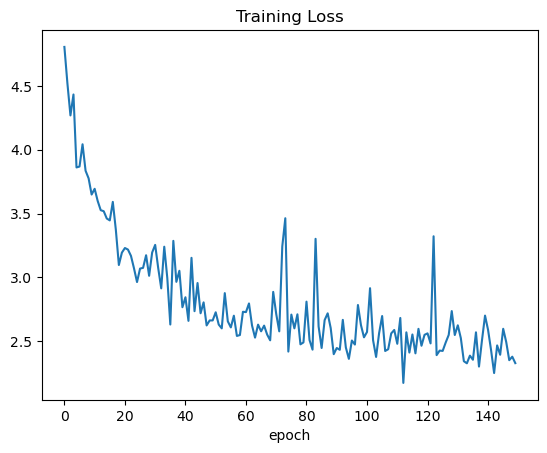

In [125]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set 

model = train_OSPWDPLSM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=150,
    num_placeholders=20,
    pre_dim=50,
    post_dim=2,
    alpha=2.0,
    beta=.7,
    gamma=.2,
    plot=True,
)

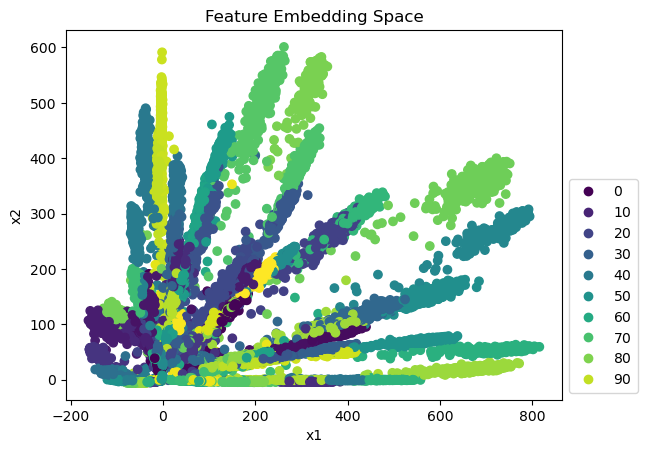

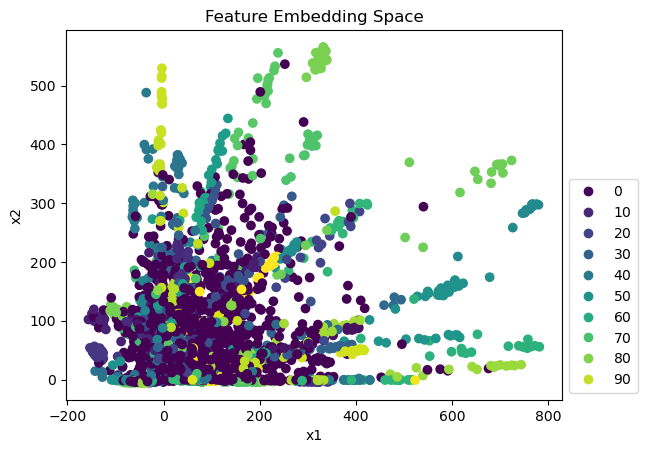

In [126]:
plot_post_embeddings(model, X, y)
y_val_open = modify_open_set_labels(y_val, OPEN_SET_LABELS)
plot_post_embeddings(model, X_val, y_val_open)